In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%store -r df 

pd.set_option('display.width', 200)  # Set a large width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping


print(df)

                                   open          high        low       close       volume  trade_count          vwap
symbol  timestamp                                                                                                   
BTC/USD 2021-01-01 06:00:00  29255.7100  29682.290000  28707.560  29676.7900   848.874030      29639.0  29316.444625
        2021-01-02 06:00:00  29678.3400  34200.000000  29555.990  33769.5200  2144.592516      60152.0  31941.412694
        2021-01-03 06:00:00  33769.5200  34812.930000  32300.610  32908.0200  1838.695433      58725.0  33505.269474
        2021-01-04 06:00:00  32907.3600  33496.030000  27900.000  30441.5700  2711.189503      69226.0  31267.965121
        2021-01-05 06:00:00  30461.8400  35851.420000  29927.550  35063.0000  1756.751333      61880.0  33151.367357
...                                 ...           ...        ...         ...          ...          ...           ...
ETH/USD 2025-03-03 06:00:00   2449.5135   2449.513500   2003.342

## VWAP Crossover Trade Signals

In [181]:
df_reset = df #.copy()  # Avoid modifying input DataFrame

def generate_basic_vwap_signals(df_reset):
    # Reset index to work with symbol and timestamp as columns
    #df = df.reset_index()

   
    df_reset = df_reset.reset_index()

    # Create signals dataframe
    signals = pd.DataFrame(index=df_reset.index)
    signals['symbol'] = df_reset["symbol"]
    signals['timestamp'] = df_reset['timestamp']

    # Calculate Previous close and VWAP for crossover detection
    signals['close'] = df_reset['close']
    signals['vwap'] = df_reset['vwap']
    signals['prev_close'] = df_reset['close'].shift(1)
    signals['prev_vwap'] = df_reset['vwap'].shift(1)

    # Generate signals 
    # Buy: previous close below previous VWAP and current close above current VWAP
    # Sell: previous close above previous VWAP and current close below current VWAP
    signals['signal'] = 0 # Default no signal
    signals.loc[(signals['prev_close'] < signals['prev_vwap']) &
                (signals['close'] > signals['vwap']), 'signal'] = 1 #Buy
    signals.loc[(signals['prev_close'] > signals['prev_vwap']) &
                (signals['close'] < signals['vwap']), 'signal'] = -1 #Sell
    
    # Group by symbol to handle each symbol separately
    signals['symbol_change'] = signals['symbol'] != signals['symbol'].shift(1)
    signals.loc[signals['symbol_change'], ['prev_close', 'prev_vwap']] = np.nan

    # Clean up signals at symbol boundaries
    signals.loc[signals['symbol_change'], 'signal'] = 0

    # Drop temporary columns
    signals = signals.drop(['prev_close', 'prev_vwap', 'symbol_change'], axis=1)

    # Set index back to symbol and timestamp
    signals = signals.set_index(['symbol', 'timestamp'])

    return signals

# Generate signals
signal_df = generate_basic_vwap_signals(df_reset)


# Merge signals with original dataframe if needed 
#result_df = df_reset.join(signal_df['signal'])
result_df = df_reset.merge(signal_df[['signal']], on=['symbol', 'timestamp'], how='left')


# Display sample of results
print("\nSample of result with signals:")
print(result_df[['close', 'vwap', 'signal']].head(10))

# Count signals by symbol
print("\nSignal counts by symbol:")
print(result_df.groupby('symbol')['signal'].value_counts())




Sample of result with signals:
                                close          vwap  signal
symbol  timestamp                                          
BTC/USD 2021-01-01 06:00:00  29676.79  29316.444625       0
        2021-01-02 06:00:00  33769.52  31941.412694       0
        2021-01-03 06:00:00  32908.02  33505.269474      -1
        2021-01-04 06:00:00  30441.57  31267.965121       0
        2021-01-05 06:00:00  35063.00  33151.367357       1
        2021-01-06 06:00:00  37485.27  35720.825762       0
        2021-01-07 06:00:00  38009.79  38472.947353      -1
        2021-01-08 06:00:00  39379.24  40360.705381       0
        2021-01-09 06:00:00  40547.42  40539.899845       1
        2021-01-10 06:00:00  34860.75  37212.352596      -1

Signal counts by symbol:
symbol   signal
BTC/USD   0        720
         -1        404
          1        403
ETH/USD   0        724
         -1        402
          1        401
Name: count, dtype: int64


In [182]:
print(df_reset.columns)


Index(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], dtype='object')


In [183]:
df_reset = df_reset.reset_index()


## Integrate Supertrend for signal confirmation

In [184]:
import pandas as pd
import numpy as np

def calculate_supertrend(df_reset, period=7, multiplier=2.0):
    """Calculate Supertrend indicator"""
    df_reset = df_reset.copy()
    
    # Calculate ATR (Average True Range)
    high_low = df_reset['high'] - df_reset['low']
    high_close = np.abs(df_reset['high'] - df_reset['close'].shift())
    low_close = np.abs(df_reset['low'] - df_reset['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(period).mean()
    
    # Calculate basic upper and lower bands
    hl2 = (df_reset['high'] + df_reset['low']) / 2
    upper_band = hl2 + (multiplier * atr)
    lower_band = hl2 - (multiplier * atr)
    
    # Initialize Supertrend
    supertrend = pd.Series(np.zeros(len(df_reset)), index=df_reset.index)
    final_upper = pd.Series(np.zeros(len(df_reset)), index=df_reset.index)
    final_lower = pd.Series(np.zeros(len(df_reset)), index=df_reset.index)
    
    # Calculate Supertrend
    for i in range(period, len(df_reset)):
        # Adjust bands based on previous close
        if df_reset['close'].iloc[i-1] <= final_upper.iloc[i-1]:
            final_upper.iloc[i] = min(upper_band.iloc[i], final_upper.iloc[i-1])
        else:
            final_upper.iloc[i] = upper_band.iloc[i]
            
        if df_reset['close'].iloc[i-1] >= final_lower.iloc[i-1]:
            final_lower.iloc[i] = max(lower_band.iloc[i], final_lower.iloc[i-1])
        else:
            final_lower.iloc[i] = lower_band.iloc[i]
            
        # Determine trend direction
        if (supertrend.iloc[i-1] > 0 and df_reset['close'].iloc[i] > final_upper.iloc[i-1]) or \
           (supertrend.iloc[i-1] <= 0 and df_reset['close'].iloc[i] > final_upper.iloc[i]):
            supertrend.iloc[i] = 1  # Uptrend
        elif (supertrend.iloc[i-1] < 0 and df_reset['close'].iloc[i] < final_lower.iloc[i-1]) or \
             (supertrend.iloc[i-1] >= 0 and df_reset['close'].iloc[i] < final_lower.iloc[i]):
            supertrend.iloc[i] = -1  # Downtrend
        else:
            supertrend.iloc[i] = supertrend.iloc[i-1]
    
    return supertrend

def generate_vwap_super_signals(df_reset, supertrend_period=7, supertrend_multiplier=2.0):
    # Reset index to work with symbol and timestamp as columns
    df_reset = df_reset.reset_index()
    
    # Create signals dataframe
    signals = pd.DataFrame(index=df_reset.index)
    signals['symbol'] = df_reset['symbol']
    signals['timestamp'] = df_reset['timestamp']
    signals['close'] = df_reset['close']
    signals['vwap'] = df_reset['vwap']
    
    # Calculate previous values for VWAP crossover
    signals['prev_close'] = df_reset['close'].shift(1)
    signals['prev_vwap'] = df_reset['vwap'].shift(1)

    # Calculate Supertrend for confirmation
    # Use transform instead of apply to avoid grouping column issues
    required_cols = ['high', 'low', 'close']
    supertrend = (df_reset.groupby('symbol')[required_cols]
                 .apply(lambda x: calculate_supertrend(x, supertrend_period, supertrend_multiplier),
                        include_groups=False)  # Explicitly exclude grouping columns
                 .reset_index(level=0, drop=True))
    signals['supertrend'] = supertrend
    
    # Generate raw VWAP crossover signals
    signals['raw_signal'] = 0
    signals.loc[(signals['prev_close'] < signals['prev_vwap']) & 
                (signals['close'] > signals['vwap']), 'raw_signal'] = 1  # Buy
    signals.loc[(signals['prev_close'] > signals['prev_vwap']) & 
                (signals['close'] < signals['vwap']), 'raw_signal'] = -1  # Sell
    
    # Apply Supertrend confirmation 
    signals['signal'] = 0
    signals.loc[(signals['raw_signal'] == 1) & 
                (signals['supertrend'] > 0), 'signal'] = 1  # Buy only if Supertrend bullish
    signals.loc[(signals['raw_signal'] == -1) & 
                (signals['supertrend'] < 0), 'signal'] = -1  # Sell only if Supertrend bearish
    
    
    # Handle symbol boundaries
    signals['symbol_change'] = signals['symbol'] != signals['symbol'].shift(1)
    signals.loc[signals['symbol_change'], ['prev_close', 'prev_vwap', 'supertrend']] = np.nan
    signals.loc[signals['symbol_change'], 'signal'] = 0
    
    # Clean up
    signals = signals.drop(['prev_close', 'prev_vwap', 'symbol_change', 'raw_signal'], axis=1)
    signals = signals.set_index(['symbol', 'timestamp'])
    
    return signals

# Generate signals with Supertrend confirmation
signal_df = generate_vwap_super_signals(df_reset, supertrend_period=7, supertrend_multiplier=2.0)

# Reset index to align them
df_reset = df_reset.reset_index(drop=True)
signal_df = signal_df.reset_index(drop=True)

# Now join them
result_df = df_reset.join(signal_df[['signal', 'supertrend']])
# Merge with original dataframe
#result_df = df_reset.join(signal_df[['signal', 'supertrend']])

# Display results
print("\nSample of results with VWAP and Supertrend signals:")
print(result_df[['close', 'vwap', 'supertrend', 'signal']].head(10))

# Count signals by symbol
print("\nSignal counts by symbol:")
print(result_df.groupby('symbol')['signal'].value_counts())

# Calculate signal frequency
total_signals = result_df['signal'].abs().sum()
total_periods = len(result_df)
print(f"\nSignal frequency: {total_signals/total_periods:.4f} ({total_signals} signals in {total_periods} periods)")


Sample of results with VWAP and Supertrend signals:
      close          vwap  supertrend  signal
0  29676.79  29316.444625         NaN       0
1  33769.52  31941.412694         0.0       0
2  32908.02  33505.269474         0.0       0
3  30441.57  31267.965121         0.0       0
4  35063.00  33151.367357         0.0       0
5  37485.27  35720.825762         0.0       0
6  38009.79  38472.947353         0.0       0
7  39379.24  40360.705381         0.0       0
8  40547.42  40539.899845         0.0       0
9  34860.75  37212.352596         0.0       0

Signal counts by symbol:
symbol   signal
BTC/USD   0        1142
          1         200
         -1         185
ETH/USD   0        1153
         -1         201
          1         173
Name: count, dtype: int64

Signal frequency: 0.2485 (759 signals in 3054 periods)


In [185]:
print(result_df.columns)


Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'signal', 'supertrend'], dtype='object')


# Defining a Backtest Function

In [186]:
# --- Backtest Function ---
def backtest_strategy(result_df, initial_capital=10000, transaction_cost=0.001):
    symbols = result_df.index.get_level_values('symbol').unique()
    performance = {}
    
    for symbol in symbols:
        df_symbol = result_df.xs(symbol, level='symbol').copy()
        df_symbol['returns'] = df_symbol['close'].pct_change()
        df_symbol['strategy_returns'] = 0.0
        df_symbol['position'] = 0
        
        current_position = 0
        for i in range(1, len(df_symbol)):
            signal = df_symbol['signal'].iloc[i]
            prev_position = df_symbol['position'].iloc[i-1]
            
            if signal == 1 and current_position == 0:  # Enter long
                current_position = 1
            elif signal == -1 and current_position == 0:  # Enter short
                current_position = -1
            elif signal != 0 and current_position != 0:  # Exit on opposite signal
                current_position = 0
            
            df_symbol.loc[df_symbol.index[i], 'position'] = current_position
            if current_position != prev_position:  # Trade occurred
                df_symbol.loc[df_symbol.index[i], 'strategy_returns'] = -transaction_cost
            if current_position != 0:
                df_symbol.loc[df_symbol.index[i], 'strategy_returns'] += current_position * df_symbol['returns'].iloc[i]
        
        df_symbol['capital'] = initial_capital * (1 + df_symbol['strategy_returns']).cumprod()
        total_return = (df_symbol['capital'].iloc[-1] / initial_capital) - 1
        sharpe_ratio = (df_symbol['strategy_returns'].mean() / df_symbol['strategy_returns'].std()) * np.sqrt(252)
        max_drawdown = (df_symbol['capital'].cummax() - df_symbol['capital']).max() / df_symbol['capital'].cummax().max()
        
        performance[symbol] = {
            'Total Return': total_return,
            'Sharpe Ratio': sharpe_ratio if not pd.isna(sharpe_ratio) else 0,
            'Max Drawdown': max_drawdown,
            'Number of Trades': ((df_symbol['position'] != df_symbol['position'].shift()) & 
                                (df_symbol['position'] != 0)).sum()
        }
        
        print(f"\nPerformance for {symbol}:")
        print(pd.Series(performance[symbol]))
    
    return performance


## Running Backtest for VWAP + Supertrend

In [187]:
# Generate VWAP + Supertrend signals
supertrend_signal_df = generate_vwap_super_signals(df_reset, supertrend_period=7, supertrend_multiplier=2.5)

# Reset index to align DataFrames
df_reset = df_reset.reset_index(drop=True)
supertrend_signal_df = supertrend_signal_df.reset_index(drop=True)

# Ensure 'symbol' exists in supertrend_signal_df
if 'symbol' not in supertrend_signal_df.columns:
    supertrend_signal_df['symbol'] = df_reset['symbol']

# Concatenate the DataFrames column-wise
supertrend_result_df = pd.concat([df_reset, supertrend_signal_df[['signal', 'supertrend']]], axis=1)

# Ensure 'symbol' is set as an index (if required by backtest function)
if 'symbol' in supertrend_result_df.columns:
    supertrend_result_df = supertrend_result_df.set_index('symbol', append=True)

# # Debugging Outputs
# print("df_reset index:", df_reset.index.names)
# print("supertrend_signal_df index:", supertrend_signal_df.index.names)
# print("supertrend_result_df index:", supertrend_result_df.index.names)

print("df_reset columns:", df_reset.columns)
print("supertrend_signal_df columns:", supertrend_signal_df.columns)

# Print signal counts
print("\nSignal Counts for VWAP + Supertrend:")
print(supertrend_result_df.groupby('symbol')['signal'].value_counts())

# Backtest Strategy
print("\nBacktest Results for VWAP + Supertrend:")
performance_supertrend = backtest_strategy(supertrend_result_df)


df_reset columns: Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], dtype='object')
supertrend_signal_df columns: Index(['close', 'vwap', 'supertrend', 'signal', 'symbol'], dtype='object')

Signal Counts for VWAP + Supertrend:
symbol   signal
BTC/USD   0        1140
          1         201
         -1         186
ETH/USD   0        1148
         -1         206
          1         173
Name: count, dtype: int64

Backtest Results for VWAP + Supertrend:

Performance for BTC/USD:
Total Return          2.417356
Sharpe Ratio          0.749779
Max Drawdown          0.236969
Number of Trades    194.000000
dtype: float64

Performance for ETH/USD:
Total Return          2.355440
Sharpe Ratio          0.667374
Max Drawdown          0.407368
Number of Trades    190.000000
dtype: float64


## EDA on Signals

               close           vwap   supertrend
count    3054.000000    3054.000000  3052.000000
mean    23686.452670   23671.794849     0.013761
std     26146.189306   26122.557378     0.992503
min       733.650000     731.807780    -1.000000
25%      2292.217625    2294.015789    -1.000000
50%     10304.475000   10337.574865     0.000000
75%     41359.197500   41294.835866     1.000000
max    106855.344500  106708.386342     1.000000


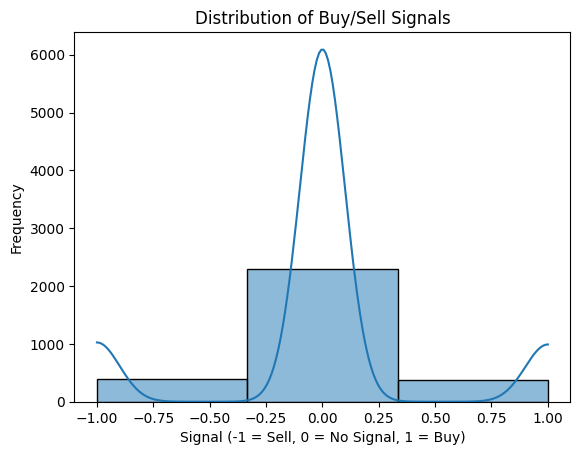

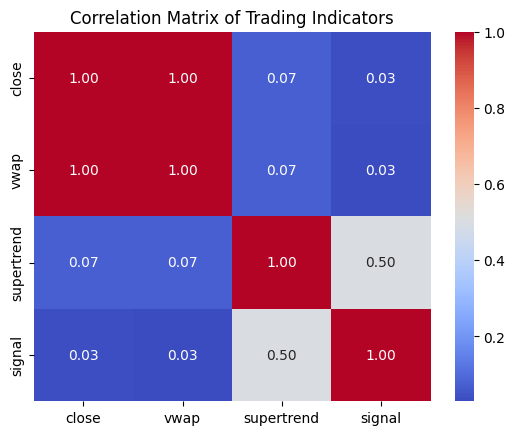

In [188]:
# Check data statistics
print(result_df[['close', 'vwap', 'supertrend']].describe())

# Check signal distribution
sns.histplot(result_df['signal'], bins=3, kde=True)
plt.title("Distribution of Buy/Sell Signals")
plt.xlabel("Signal (-1 = Sell, 0 = No Signal, 1 = Buy)")
plt.ylabel("Frequency")
plt.show()

# Correlation matrix
corr_matrix = result_df[['close', 'vwap', 'supertrend', 'signal']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Trading Indicators")
plt.show()


# Visualize Trade Signals


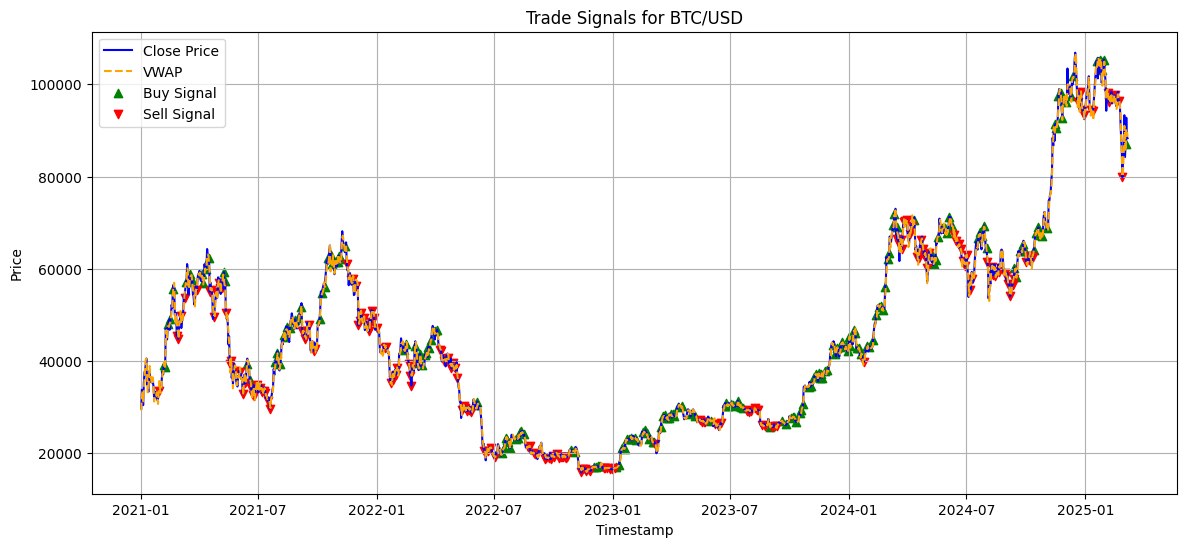

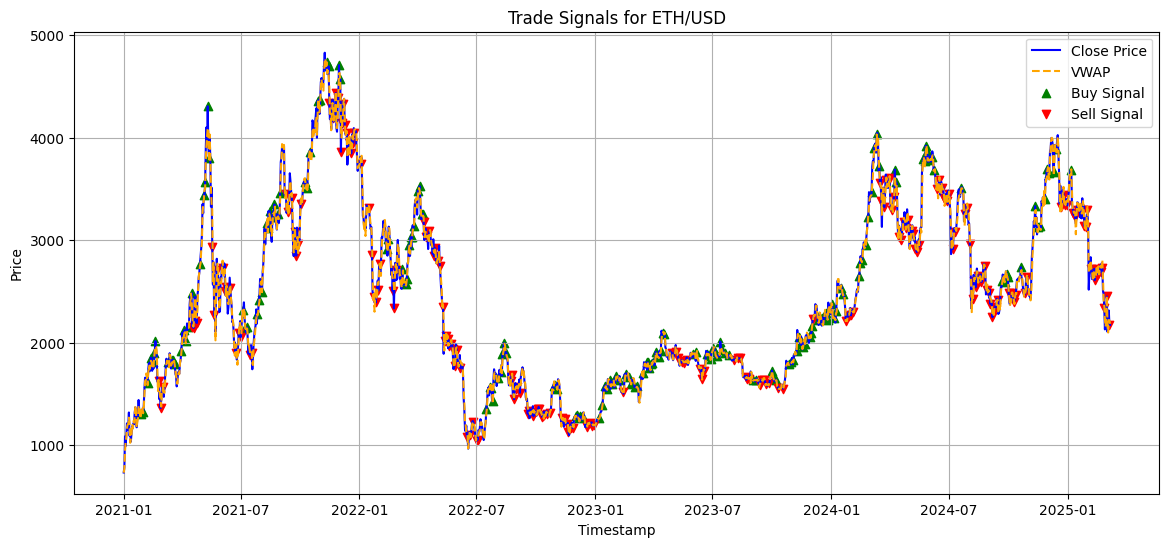

In [ ]:
def plot_signals(result_df, symbol):
    asset_df = result_df[result_df['symbol'] == symbol].copy()
    
    plt.figure(figsize=(14, 6))
    plt.plot(asset_df['timestamp'], asset_df['close'], label="Close Price", color="blue")
    plt.plot(asset_df['timestamp'], asset_df['vwap'], label="VWAP", color="orange", linestyle="dashed")

    # Plot buy signals
    buy_signals = asset_df[asset_df['signal'] == 1]
    plt.scatter(buy_signals['timestamp'], buy_signals['close'], label="Buy Signal", color="green", marker="^", alpha=1)

    # Plot sell signals
    sell_signals = asset_df[asset_df['signal'] == -1]
    plt.scatter(sell_signals['timestamp'], sell_signals['close'], label="Sell Signal", color="red", marker="v", alpha=1)

    plt.title(f"Trade Signals for {symbol}")
    plt.xlabel("Timestamp")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

# Plot for BTC/USD and ETH/USD
plot_signals(result_df, 'BTC/USD')
plot_signals(result_df, 'ETH/USD')
